# Jet - GenJet matching for JER
Using the NanoAOD branch instead of the manual matching

In [9]:
%load_ext snakeviz

In [1]:
from collections.abc import Iterable
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import numba
import correctionlib
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
nevts = 10000
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=nevts).events()

In [3]:
events.Jet.genJetIdx

<Array [[0, 1, 2, 3, 4, 5, ... 7, 4, 6, 5, 9]] type='10000 * var * int32[paramet...'>

In [4]:
events.GenJet[events.Jet.genJetIdx]

ValueError: in ListArray64 attempting to get 14, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [5]:
Ngenjet = ak.num(events.GenJet)

In [6]:
max_index = ak.max(events.Jet.genJetIdx, axis=1)

In [7]:
Ngenjet

<Array [10, 9, 13, 9, 6, 6, ... 7, 9, 7, 5, 13] type='10000 * int64'>

In [8]:
ak.sum(max_index > Ngenjet) 

522

### Taking only the pairs were the index is small enough

In [3]:
Ngenjet = ak.num(events.GenJet)
matching_with_none = ak.mask(events.Jet.genJetIdx, (events.Jet.genJetIdx < Ngenjet)&(events.Jet.genJetIdx!=-1))
#matching_with_none = ak.mask(matching, matching!=-1)
genJets = events.GenJet[matching_with_none]
not_none = ~ak.is_none(genJets, axis=1)

In [4]:
matched_jets = ak.mask(events.Jet, not_none)

In [12]:
matching_with_none[9].tolist()

[0, 1, 2, 5, 3, 4, 7, 6, 8, None, 9, None]

In [185]:
matched_jets.pt[9].tolist()

[85.0,
 68.0,
 62.25,
 51.5625,
 50.34375,
 38.875,
 38.84375,
 31.3125,
 22.359375,
 None,
 20.765625,
 None]

In [171]:
genJets[9].pt.tolist()

[72.40778350830078,
 72.30656433105469,
 61.75617599487305,
 38.85511779785156,
 45.20153045654297,
 40.798851013183594,
 21.359764099121094,
 26.313899993896484,
 18.751693725585938,
 None,
 14.176642417907715,
 None]

In [35]:
events.Jet.genJetIdx[2]

<Array [1, 0, 2, 3, 7, 6, 8, 12, 5, 14] type='10 * int32[parameters={"__doc__": ...'>

In [33]:
matching[2]

<Array [1, 0, 2, 3, 7, 6, 8, 12, 5] type='9 * int32[parameters={"__doc__": "inde...'>

In [73]:
matching[8].tolist()

[0, 2, 3, 1, 4, 5, 6, 7, -1, -1]

In [13]:
matching_with_none[0:10].tolist()

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 3, 1, 5, 4, 6, 7, 8, None],
 [1, 0, 2, 3, 7, 6, 8, 12, 5, None],
 [0, 2, 1, 3, 4, 6, 5, 7],
 [1, 0, 2, 3, 4],
 [1, 2, 0, None, 3, 4, 5],
 [0, 2, 1, 3, 4, 6],
 [0, 2, 1, 3, 4, 6, 5, 7, 11, None, 10],
 [0, 2, 3, 1, 4, 5, 6, 7, None, None],
 [0, 1, 2, 5, 3, 4, 7, 6, 8, None, 9, None]]

In [25]:
def delta_pt(jets, genJets, builder):
    for js , genJs in zip(jets, genJets):
        builder.begin_list()
        for j, g in zip(js, genJs):
            builder.append(abs(j-g)
        builder.end_list()
    return builder

SyntaxError: invalid syntax (3318437109.py, line 6)

In [ ]:
%timeit delta_pt(events.Jet[not_none], genJets[not_none], ak.ArrayBuilder())

In [10]:
@numba.njit
def delta_pt_numba(jets, genJets, mask, builder):
    for js , genJs, ms in zip(jets, genJets, mask):
        builder.begin_list()
        for j, g, m in zip(js, genJs, ms):
            if m:
                builder.append(abs(j-g))
            else:
                builder.append(None)
        builder.end_list()
    return builder

In [24]:
genJets.pt.type

10000 * var * ?float32[parameters={"__doc__": "pt"}]

In [19]:
delta_pt_numba(matched_jets.pt, genJets.pt , not_none, ak.ArrayBuilder())

<ArrayBuilder [[8.74, 1.47, 4.34, ... 1.73, 3.77]] type='10000 * var * ?float64'>

In [45]:
%timeit delta_pt_numba(events.Jet.pt, genJets.pt , not_none, ak.ArrayBuilder())

12.5 ms ± 742 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
dPt1 = delta_pt_numba(events.Jet.pt, genJets.pt , not_none, ak.ArrayBuilder())

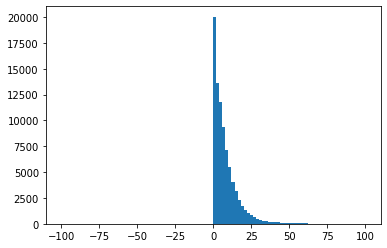

In [16]:
plt.hist(ak.flatten(dPt), bins=100, range=(-100,100))
plt.show()

In [46]:
%%timeit
dPt = ak.unflatten(np.abs(ak.flatten(matched_jets.pt) - ak.flatten(genJets.pt)), ak.num(genJets.pt))

7.75 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
dPt2 = ak.unflatten(np.abs(ak.flatten(matched_jets.pt) - ak.flatten(genJets.pt)), ak.num(genJets.pt))

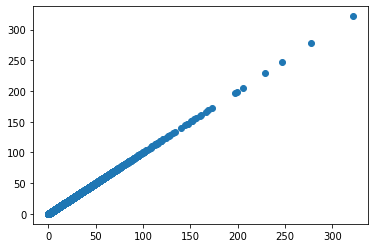

In [44]:
plt.scatter(ak.flatten(dPt1[not_none]), ak.flatten(dPt2[not_none]))
plt.show()